In [1]:
import os
import sys
import time
import sqlite3

from Functions.database import createTable
from Functions.FunctionsDataVisualization import distOutputLayer

import tensorboard as tf
import keras.backend as K
from envConfig import CONFIG
CONFIG["PACKAGE_NAME"] = os.path.join(CONFIG["OUTPUTDATAPATH"], "Classification")

import matplotlib.pyplot as plt


import numpy as np
import pandas as pd

import seaborn as sns


analysis_name = 'Classification'

data_path = CONFIG['OUTPUTDATAPATH']
results_path = CONFIG['PACKAGE_NAME']


#db = sqlite3.connect(results_path+'classification.db')
#time = time.strftime("%a, %d %b %Y %H:%M:%S", time.gmtime())

Using TensorFlow backend.


In [2]:
from Functions.dataset.shipClasses import LoadData

dt_24 = LoadData(dev=False)
#dt_24.infoData()
all_data,all_trgt= dt_24.getData()

[+] Time to read data file: 3.68855690956 seconds


In [3]:
K.clear_session()

In [4]:
from Functions.preprocessing import CrossValidation

results_path_specific = results_path + '/dev' + '/PCD_HierNet'
if not os.path.exists(results_path_specific):
    os.makedirs(results_path_specific)

cv = CrossValidation(X = all_data,y = all_trgt, estimator=None, n_folds=10, dev=True, verbose=1, dir=results_path_specific)



train_id, test_id, folder = cv.train_test_split(ifold=5)

File /home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/PCD_HierNet/10_folds_cross_validation_dev.jbl exists


In [6]:
from Functions.mlpClassification import MLPKeras
from Functions.preprocessing import CrossValidation,CVEnsemble
from Functions.ensemble import SpecialistClass,HierarqNet,HierarqClassification
from Functions.principal_components import PCDCooperative, TrnParams

import sklearn as sk

classes={'class_S':[[9,10,13,14,16,23,1,2,22,21],
                             [4,6,8,12,17,19],
                             [11,24],
                             [5,7,15,3,18,20]],
        'class_A':[[9,10,13,14,16],
                        [23,1,2,22],
                        [21]],
        'class_B':[[4],
                        [6],
                        [8],
                        [12],
                        [17],
                        [19]],
        'class_D':[[5,7,15],
                [3,18,20]],
         
        'class_C':[[11],
                    [24]],
        'class_AA':[[9],
                         [10],
                         [13],
                         [14],
                         [16]],
        'class_AB':[[23],
                         [1],
                         [2],
                         [22]],
        'class_DA':[[5],
                         [7],
                         [15]],
        'class_DB':[[3],
                         [18],
                         [20]]}

map_lvl = {
    'class_S':0,
    'class_A':1,
    'class_AA':2,
    'class_AB':2,
    'class_AC':2,
    'class_B':1,
    'class_C':1,
    'class_D':1,
    'class_DA':2,
    'class_DB':2
}

trn = TrnParams(learning_rate=0.001,monitor='sp',verbose=True,batch_size=512,n_inits=1,n_epochs=1000)

pcd = PCDCooperative(n_components=25,
                     is_save=True,
                     trn_params=trn,
                     validation_id=(None,None))

hn = HierarqClassification(estimator=pcd,
                           dict_classes=classes,
                           map_members=map_lvl,
                           n_lvl=3,
                           file=results_path_specific,
                           load=False)

In [17]:
hn._prepare_table(y=all_trgt,load=hn.load)
hn._add_ifold_df(y=all_trgt,ifold=5,test_id=test_id,train_id=train_id)
hn.fit_member(member='class_A',X=all_data,y=all_trgt,ifold=5)

PCD Cooperative Extractor
Class TrnParams
 verbose: True
 nesterov: True
 learning_rate: 0.001
 n_inits: 1
 batch_size: 512
 n_epochs: 1000
 train_verbose: False
 patience: 25
 learning_decay: 1e-06
 mode: auto
 momentum: 0.3
 monitor: sp

[PCD Cooperative Extractor]: PCD Loop
 Extracting 0 PCD
[     0      1      2 ... 206344 206345 206346]
 Extracting 1 PCD
 Extracting 2 PCD
 Extracting 3 PCD
 Extracting 4 PCD
 Extracting 5 PCD
 Extracting 6 PCD
 Extracting 7 PCD
 Extracting 8 PCD
 Extracting 9 PCD
 Extracting 10 PCD
 Extracting 11 PCD
 Extracting 12 PCD
 Extracting 13 PCD
 Extracting 14 PCD
 Extracting 15 PCD
 Extracting 16 PCD
 Extracting 17 PCD
 Extracting 18 PCD
 Extracting 19 PCD
 Extracting 20 PCD
 Extracting 21 PCD
 Extracting 22 PCD
 Extracting 23 PCD
 Extracting 24 PCD


PCDCooperative(activation='tanh',
        dir='/home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/PCD_HierNet/fold05/class_A',
        is_save=True, n_components=25,
        trn_params=<Functions.principal_components.TrnParams object at 0x7fa853a98ad0>,
        validation_id=(array([     0,      1, ..., 206345, 206346]), array([  1605,   1606, ..., 188110, 188111])))

In [19]:
mt = hn.master_table

In [23]:
pcd_S = hn.estimators_['class_A']
df = pd.concat(pcd_S.trn_descs)
all_data_preproc = pcd_S.scaler_.transform(all_data)
pred = pcd_S.models[0].predict(all_data_preproc[test_id])

In [24]:
df_pred = pd.DataFrame(pred,columns=['neuronio {0}'.format(i)for i in range(4)])
#df_pred.plot(kind='hist',subplots=True,figsize=(10,7),grid=True)

true = mt[(mt['class_A']!=-1)&(mt['fold_05']==1)]['class_A']
distOutputLayer(predict=pred,trgt=true)

ValueError: Shape of passed values is (3, 22013), indices imply (4, 22013)

In [18]:
np.argmax(df.groupby(level=0).agg(['max'])['sp'].values)

22

In [12]:
pcd_S._y

array([[ 1., -1., -1., -1.],
       [ 1., -1., -1., -1.],
       [ 1., -1., -1., -1.],
       ...,
       [-1., -1.,  1., -1.],
       [-1., -1.,  1., -1.],
       [-1., -1.,  1., -1.]], dtype=float32)

/home/venancio/sonarteste/lib/python2.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


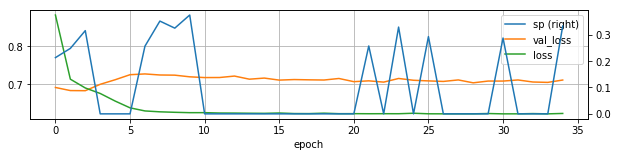

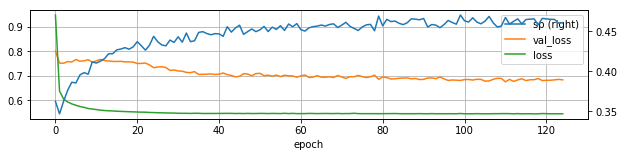

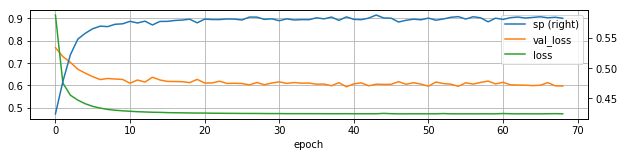

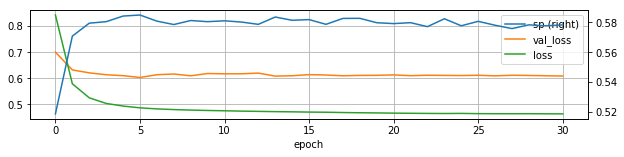

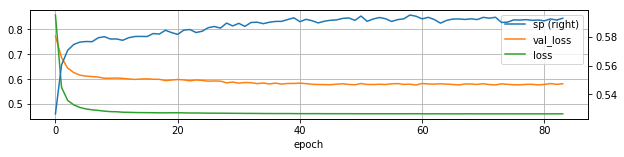

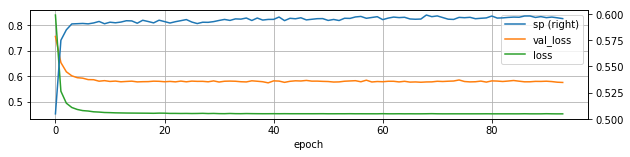

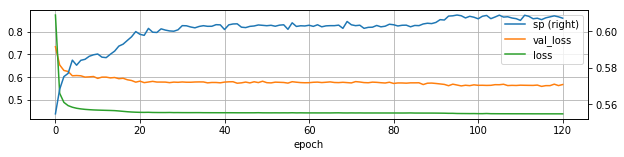

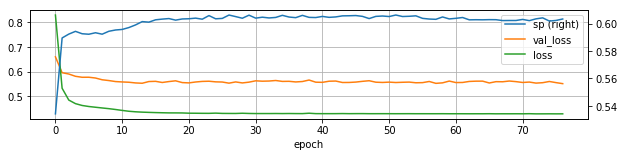

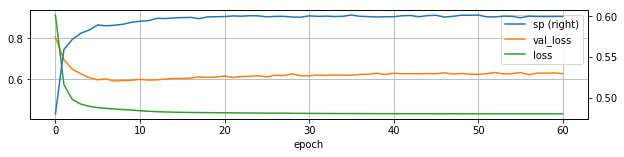

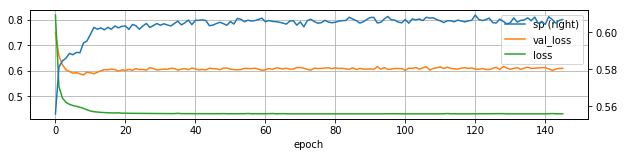

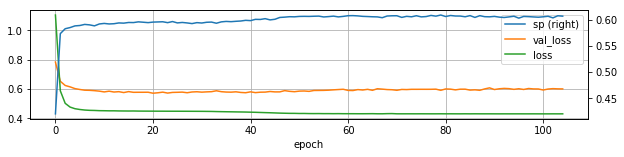

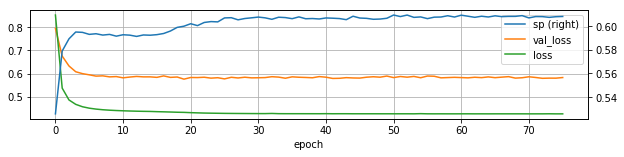

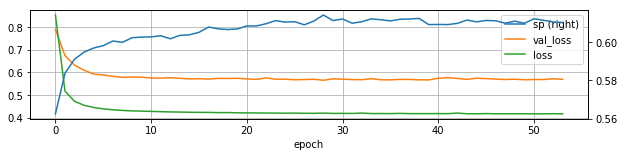

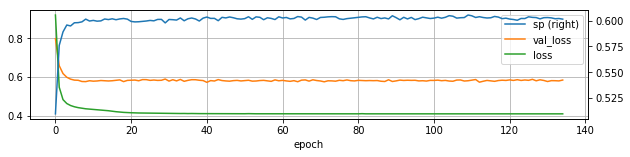

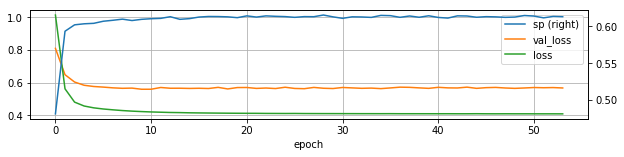

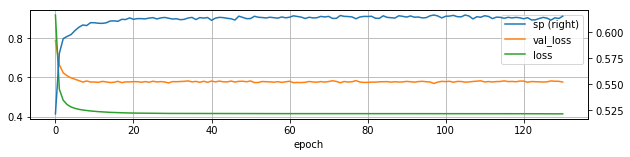

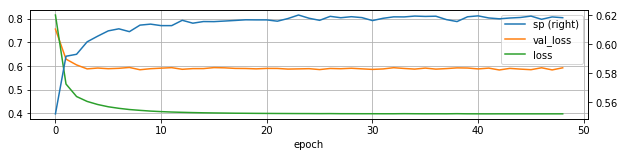

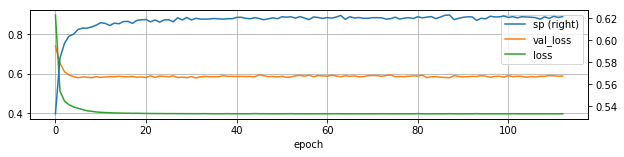

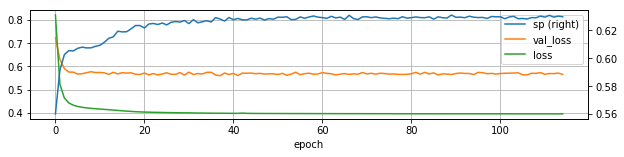

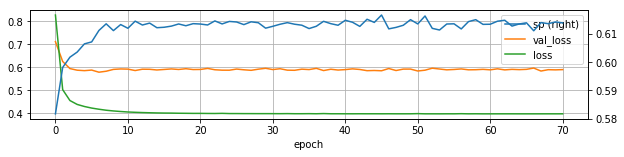

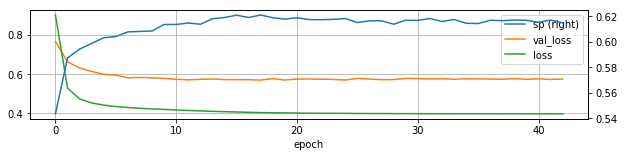

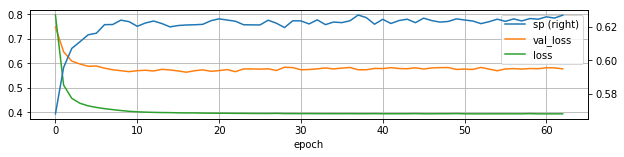

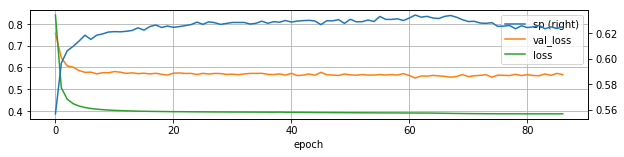

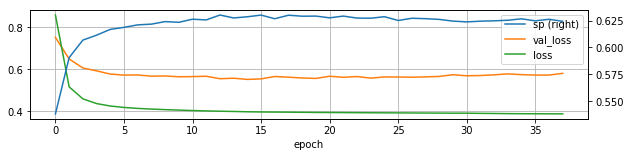

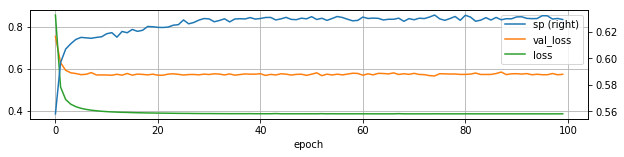

In [13]:
for i in range(pcd_S.n_components):
    df.loc[i].plot(x='epoch',y=['sp','val_loss','loss'],grid=True,figsize=(10,2),secondary_y=['sp'])

In [23]:
mt = hn.master_table
print mt[(mt['class_B']!=1)&(mt['fold_05']==0)]['class_S'].shape
print mt[(mt['class_B']!=1)&(mt['fold_05']==1)]['class_S'].shape

(196141,)
(21790,)


In [24]:
all_data[mt[(mt['class_B']!=1)&(mt['fold_05']==0)]['class_S'].index].shape

(196141, 400)

In [37]:
np.unique(mt['class_S'].values)

array([0, 1, 2, 3])

In [22]:
pcd_S.get_params()['dir']

'/home/venancio/Workspace/SonarAnalysis/Results/Classification/dev/PCD_HierNet//fold05/class_S'